In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sceneries/data/CameraMask/010841.png
/kaggle/input/sceneries/data/CameraMask/018431.png
/kaggle/input/sceneries/data/CameraMask/007355.png
/kaggle/input/sceneries/data/CameraMask/002712.png
/kaggle/input/sceneries/data/CameraMask/002312.png
/kaggle/input/sceneries/data/CameraMask/018421.png
/kaggle/input/sceneries/data/CameraMask/011054.png
/kaggle/input/sceneries/data/CameraMask/002735.png
/kaggle/input/sceneries/data/CameraMask/017731.png
/kaggle/input/sceneries/data/CameraMask/049288.png
/kaggle/input/sceneries/data/CameraMask/010861.png
/kaggle/input/sceneries/data/CameraMask/022240.png
/kaggle/input/sceneries/data/CameraMask/015020.png
/kaggle/input/sceneries/data/CameraMask/014385.png
/kaggle/input/sceneries/data/CameraMask/022247.png
/kaggle/input/sceneries/data/CameraMask/011480.png
/kaggle/input/sceneries/data/CameraMask/008818.png
/kaggle/input/sceneries/data/CameraMask/006884.png
/kaggle/input/sceneries/data/CameraMask/011772.png
/kaggle/input/sceneries/data/Ca

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torchvision
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device)
print(device)

cuda:0


In [4]:
class UNET(nn.Module):
    
    def __init__(self, num_classes):
        super(UNET, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [5]:
# class DoubleConv(nn.Module):
#     def __init__(self,in_channels,out_channels):
#         super(DoubleConv,self).__init__()
#         self.conv = nn.Sequential(
#         nn.Conv2d(in_channels,out_channels,3,1,1),
#         nn.ReLU(inplace=True),
#         nn.BatchNorm2d(out_channels),
        
#         nn.Conv2d(out_channels,out_channels,3,1,1),
#         nn.ReLU(inplace=True),
#         nn.BatchNorm2d(out_channels),
#         )
#     def forward(self,x):
#         return self.conv(x)

In [6]:

# import torch.nn.functional as F


# class UNET(nn.Module):
#     def __init__(
#         self, in_channels, out_channels, features=[64, 128, 256, 512]
#     ):
#         super(UNET, self).__init__()
#         self.ups = nn.ModuleList()
#         self.downs = nn.ModuleList()
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

#         for feature in features:
#             self.downs.append(DoubleConv(in_channels, feature))
#             in_channels = feature

#         for feature in reversed(features):
#             self.ups.append(
#                 nn.ConvTranspose2d(
#                     feature * 2, feature, kernel_size=2, stride=2
#                 )
#             )
#             self.ups.append(DoubleConv(feature * 2, feature))

#         self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
#         self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

#     def forward(self, x):
#         skip_connections = []

#         for down in self.downs:
#             x = down(x)
#             skip_connections.append(x)
#             x = self.pool(x)

#         x = self.bottleneck(x)
#         skip_connections = skip_connections[::-1]  # reverses the order of skip connections

#         for idx in range(0, len(self.ups), 2):
#             x = self.ups[idx](x)
#             skip_connection = skip_connections[idx // 2]
#             # Exception case --warning--
#             if x.shape != skip_connection.shape:
#                  x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=False)

#             concat_skip = torch.cat((skip_connection, x), dim=1)
#             x = self.ups[idx + 1](concat_skip)

#         return self.final_conv(x)


In [7]:
# def test():
#     x=torch.randn((4,3,96,128))
#     model=UNET(in_channels=3,out_channels=3)
#     preds=model(x)
#     print(preds.shape)
#     print(x.shape)
#     assert preds.shape ==x.shape

In [8]:
# test()

In [9]:
path = '/kaggle/input/sceneries'
image_path = os.path.join(path, 'data/CameraRGB/')  
mask_path = os.path.join(path, 'data/CameraMask/')  
image_list_orig = os.listdir(image_path)
image_list = [os.path.join(image_path, i) for i in image_list_orig]
mask_list = [os.path.join(mask_path, i) for i in image_list_orig]


/tmp/ipykernel_26/2127741555.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
/tmp/ipykernel_26/2127741555.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

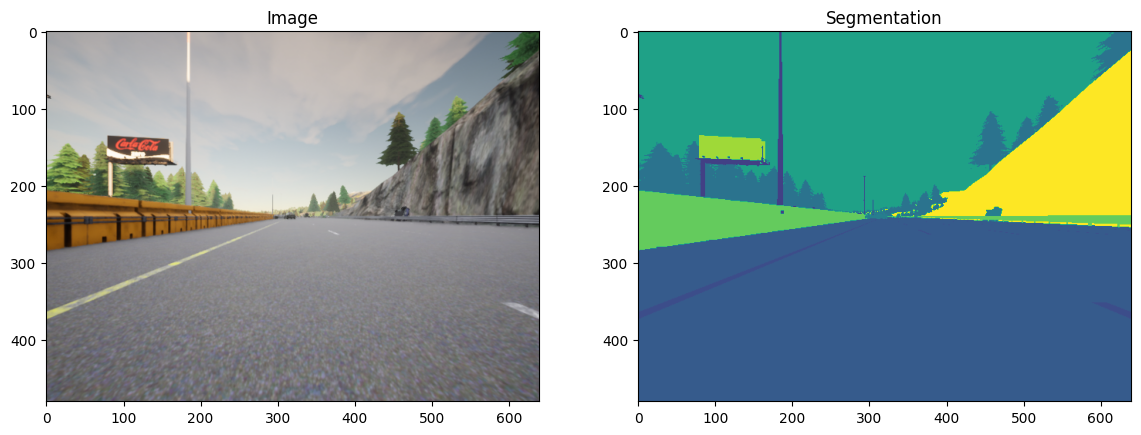

In [10]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

In [11]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, image_list, mask_list, transform=None, mask_transform=None):
        self.image_list = image_list
        self.mask_list = mask_list
        self.transform = transform
        self.mask_transform = mask_transform
        

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = self.image_list[idx]
        mask_path = self.mask_list[idx]

        # Load the image and mask
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            mask = mask.squeeze(0)

        return image, mask

# Define the transformation with normalization and resizing
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
   
])


masked_dataset = CustomDataset(image_list, mask_list, transform=transform, mask_transform=mask_transform)


In [12]:
image,mask=masked_dataset[0]

print(image.shape)
print(mask.shape)

torch.Size([3, 256, 256])
torch.Size([256, 256])


In [13]:
mask

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
        [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
        [0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078]])

In [14]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and testing sets
train_size = 0.8  # Adjust the percentage for training set
test_size = 1 - train_size
random_seed = 42  # Set a seed for reproducibility

# Split the dataset
train_dataset, test_dataset = train_test_split(masked_dataset, test_size=test_size, random_state=random_seed)

# Create DataLoaders for training and testing
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [15]:
print(len(train_dataset),len(train_dataloader))
data_iter = iter(train_dataloader)
images,targets= next(data_iter)
print(images.shape,targets.shape)

848 53
torch.Size([16, 3, 256, 256]) torch.Size([16, 256, 256])


In [16]:
model = UNET(num_classes=10)
model = model.to(device)

In [17]:
images = images.to(device)
Y_pred =model(images)
print(Y_pred.shape)

torch.Size([16, 10, 256, 256])


In [18]:
len(test_dataset)

212

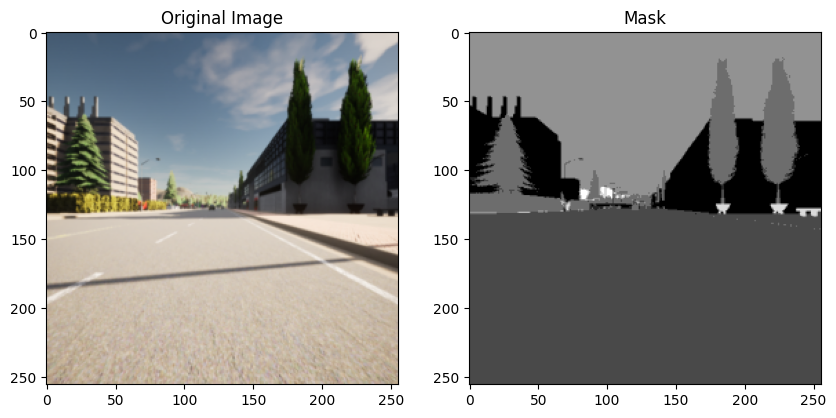

In [19]:
# Adjust the batch size based on your needs
data_loader = train_dataloader  # Choose either masked_dataloader or unmasked_dataloader

# Fetch a batch of data
batch = next(iter(data_loader))

# Unpack the batch
images, masks = batch

# Convert tensors to PIL images for display
image_to_display = torchvision.transforms.ToPILImage()(images[2])
mask_to_display = torchvision.transforms.ToPILImage()(masks[2])

# Display the original image and its mask
plt.figure(figsize=(10, 5))

# Display original image
plt.subplot(1, 2, 1)
plt.imshow(image_to_display)
plt.title("Original Image")

# Display mask
plt.subplot(1, 2, 2)
plt.imshow(mask_to_display,cmap="gray")
plt.title("Mask")

plt.show()


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm


# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of training epochs
num_epochs = 10

# Training loop
for epoch in tqdm(range(num_epochs)):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, targets in tqdm(train_dataloader,total=len(train_dataloader),leave=False):
        inputs,targets = inputs.to(device),targets.to(device)
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(inputs)
        # Calculate the loss
        # Remove the extra dimension from targets
#         targets = targets.squeeze(1).long()
        
        loss = criterion(outputs,targets.long())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        
    # Print the average training loss for the epoch
    average_loss = running_loss / len(train_dataloader)
    print(f'Training Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Training Epoch [1/10], Loss: 1.5753


  0%|          | 0/53 [00:00<?, ?it/s]

Training Epoch [2/10], Loss: 0.0825


  0%|          | 0/53 [00:00<?, ?it/s]

Training Epoch [3/10], Loss: 0.0117


  0%|          | 0/53 [00:00<?, ?it/s]

Training Epoch [4/10], Loss: 0.0062


  0%|          | 0/53 [00:00<?, ?it/s]

Training Epoch [5/10], Loss: 0.0040


  0%|          | 0/53 [00:00<?, ?it/s]

Training Epoch [6/10], Loss: 0.0028


  0%|          | 0/53 [00:00<?, ?it/s]

Training Epoch [7/10], Loss: 0.0021


  0%|          | 0/53 [00:00<?, ?it/s]

Training Epoch [8/10], Loss: 0.0016


  0%|          | 0/53 [00:00<?, ?it/s]

Training Epoch [9/10], Loss: 0.0013


  0%|          | 0/53 [00:00<?, ?it/s]

Training Epoch [10/10], Loss: 0.0011


In [21]:
model.eval()

UNET(
  (contracting_11): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (contracting_12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (contracting_21): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (contracting_22): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (contr

In [22]:
X, Y = next(iter(test_dataloader))
X, Y = X.to(device), Y.to(device)
Y_pred = model(X)
print(Y_pred.shape)

torch.Size([16, 10, 256, 256])


In [23]:
Y_pred = torch.argmax(Y_pred, dim=1)

In [24]:
Y_pred[0,:,]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')

In [25]:
X=X[0].permute(1,2,0).cpu().detach().numpy()
Y=Y[0].cpu().detach().numpy()
Y_p=Y_pred[0].cpu().detach().numpy()

In [26]:
print(X.shape,Y.shape,Y_p.shape)

(256, 256, 3) (256, 256) (256, 256)


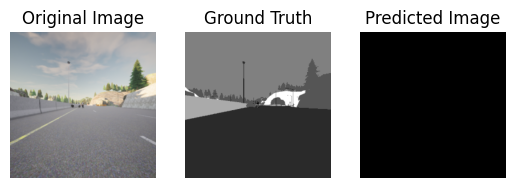

In [27]:
import matplotlib.pyplot as plt

# Assuming X, Y, and Y_pred are the variables you mentioned

# Plotting the original image (X)
plt.subplot(1, 3, 1)
plt.imshow(X)
plt.title('Original Image')
plt.axis('off')

# Plotting the ground truth (Y)
plt.subplot(1, 3, 2)
plt.imshow(Y, cmap='gray')  # Assuming Y is a grayscale image
plt.title('Ground Truth')
plt.axis('off')

# Plotting the predicted image (Y_pred)
plt.subplot(1, 3, 3)
plt.imshow(Y_p,cmap='gray')  # Assuming Y_pred is a grayscale image
plt.title('Predicted Image')
plt.axis('off')

# Show the plots
plt.show()
